In [1]:
from urllib.request import urlopen
import dateutil.parser
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12]

def download(date_extension):
    url= 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date_extension +'.txt'
    print(url)
    response = urlopen(url)
    data = response.read()

    filename = 'data/' + date_extension + ".txt"
    file_ = open(filename, 'wb')
    file_.write(data)
    file_.close()


def calculate_dates(start, end):
    temp = []
    delta = datetime.timedelta(days=7)
    y1, m1, d1 = [int(x) for x in start.strip().split("-")]
    y2, m2, d2 = [int(y) for y in end.strip().split("-")]
    sDate = datetime.datetime(y1, m1, d1)
    eDate = datetime.datetime(y2, m2, d2)
    d = sDate
    while d <= eDate:
        temp.append(d)
        d += delta
        
    return temp


dates_download = calculate_dates('2017-07-01', '2017-07-08')
for i in dates_download:
    date_ext = i.strftime("%y%m%d")
    # download(date_ext)
    

In [48]:
def calculate_total_week(date, cumulative_df):
    
    date_extension = date.strftime("%y%m%d")
    filename = 'data/' + date_extension + '.txt'
    print(filename)
    df1 = pd.read_csv(filename)
    columns = ['control_area', 'unit', 'scp', 'station', 'line_name',
            'division', 'date', 'time', 'desc', 'entries', 'exits']
    
    # rename columns
    df1.columns = columns
    
    # set the stations we want
    df = df1[(df1.station == 'TIMES SQ-42 ST') | (df1.station == '42 ST-TIMES SQ')
             | (df1.station =='FLUSHING-MAIN' ) | (df1.station == 'MAIN ST')
             | (df1.station == 'ATL AV-BARCLAY') | (df1.station =='BARCLAYS CENTER')] 
    
    df = df[df.desc != 'RECOVR AUD']
    # print(df.sample())
    # start of analysis for weekly counts
    station_date = df.groupby(['control_area','unit','scp','station','date'])
    
    entry_date_count = station_date.entries.apply(lambda x: x.max() - x.min())
    entry_date_count = entry_date_count.reset_index()

    exit_date_count = station_date.exits.apply(lambda x: x.max() - x.min())
    exit_date_count = exit_date_count.reset_index()

    # group all entries by station
    station_entry_week_count = entry_date_count.groupby('station').entries.agg(['sum'])
    station_exit_week_count = exit_date_count.groupby('station').exits.agg(['sum'])

    # total counts
    station_entry_week_count['exit sum'] = station_exit_week_count['sum']
    station_entry_week_count['total'] = station_entry_week_count['exit sum'] + station_entry_week_count['sum']
    station_entry_week_count['year_week'] = date
    station_entry_week_count['year'] = date.isocalendar()[0]
    station_entry_week_count['week_of_year'] = date.isocalendar()[1]
    station_entry_week_count = station_entry_week_count.reset_index()
   
    # remove outliers
    upper_limit = 2e6
    station_entry_week_count = station_entry_week_count[station_entry_week_count['total'] < upper_limit]
    
    cumulative_df = cumulative_df.append(station_entry_week_count.iloc[:])
    return cumulative_df

def find_min_weeks(df):
    """
    find weeks with smallest total
    """
    indexes = df['total'].argsort().values[:3]  
    df = df.iloc[indexes]
    return df

# Run analysis
dates = calculate_dates('2015-01-03', '2017-07-08')
final_week_count = pd.DataFrame()
for d in dates:
    final_week_count = calculate_total_week(d, final_week_count)
    
# for d in dates_16:
#     final_week_count_16 = calculate_total_week(d, final_week_count_16)
# final_week_count_16 = pd.DataFrame()
# for d in dates_16:
#     final_week_count_16 = calculate_total_week(d, final_week_count_16)

data/150103.txt
data/150110.txt
data/150117.txt
data/150124.txt
data/150131.txt
data/150207.txt
data/150214.txt
data/150221.txt
data/150228.txt
data/150307.txt
data/150314.txt
data/150321.txt
data/150328.txt
data/150404.txt
data/150411.txt
data/150418.txt
data/150425.txt
data/150502.txt
data/150509.txt
data/150516.txt
data/150523.txt
data/150530.txt
data/150606.txt
data/150613.txt
data/150620.txt
data/150627.txt
data/150704.txt
data/150711.txt
data/150718.txt
data/150725.txt
data/150801.txt
data/150808.txt
data/150815.txt
data/150822.txt
data/150829.txt
data/150905.txt
data/150912.txt
data/150919.txt
data/150926.txt
data/151003.txt
data/151010.txt
data/151017.txt
data/151024.txt
data/151031.txt
data/151107.txt
data/151114.txt
data/151121.txt
data/151128.txt
data/151205.txt
data/151212.txt
data/151219.txt
data/151226.txt
data/160102.txt
data/160109.txt
data/160116.txt
data/160123.txt
data/160130.txt
data/160206.txt
data/160213.txt
data/160220.txt
data/160227.txt
data/160305.txt
data/160

In [3]:
# final_week_count_16.to_csv(r'final_results.txt', header=True, sep=',')

In [4]:
final_week_count['station'].unique()

array(['ATL AV-BARCLAY', 'FLUSHING-MAIN', 'TIMES SQ-42 ST'], dtype=object)

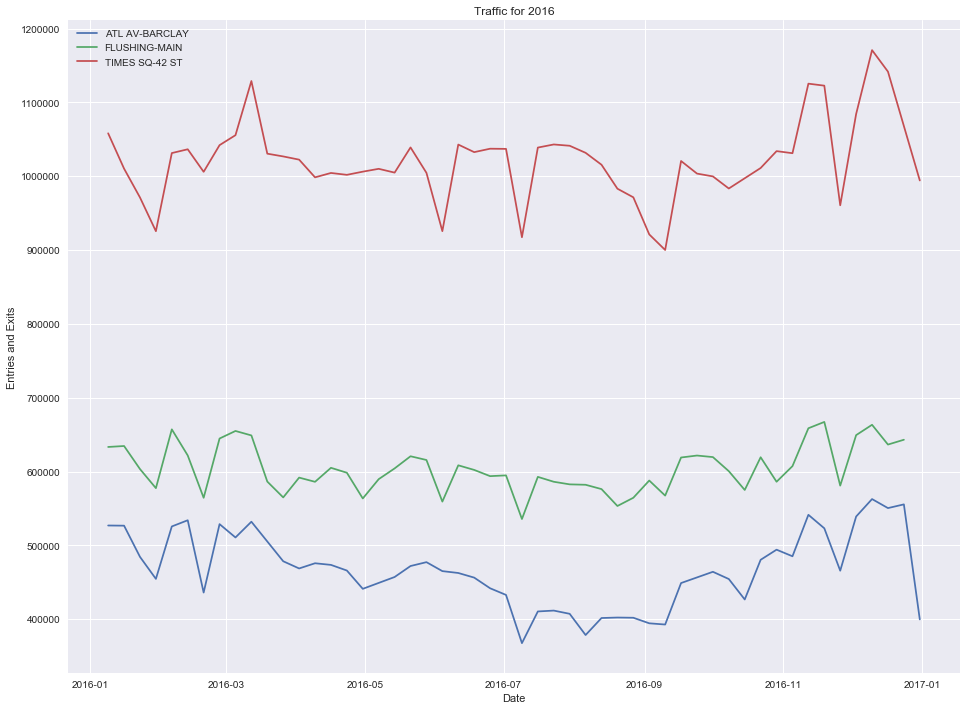

In [49]:
atl_station_16 = final_week_count[(final_week_count.station == 'ATL AV-BARCLAY') & (final_week_count.year == 2016)].reset_index()
flushing_station_16 = final_week_count[(final_week_count.station == 'FLUSHING-MAIN') & (final_week_count.year == 2016)].reset_index()
times_station_16 = final_week_count[(final_week_count.station == 'TIMES SQ-42 ST') & (final_week_count.year == 2016)].reset_index()

plt.plot(atl_station_16.year_week, atl_station_16.total, label='ATL AV-BARCLAY')
plt.plot(flushing_station_16.year_week, flushing_station_16.total, label='FLUSHING-MAIN')
plt.plot(times_station_16.year_week, times_station_16.total, label='TIMES SQ-42 ST')
plt.xlabel('Date')
plt.ylabel('Entries and Exits')
plt.title('Traffic for 2016')
plt.legend(loc='upper left')


In [6]:
#np.percentile(final_week_count.total, 99)

In [50]:
#find_min_weeks(flushing_station)

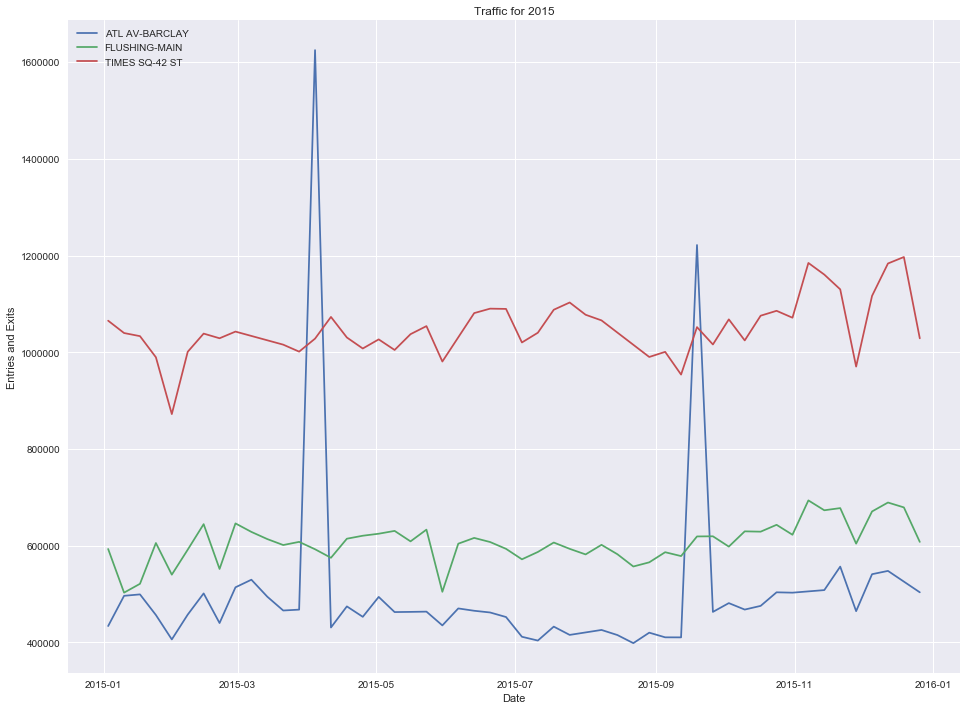

In [51]:
# Run analysis 2015 - 2016

# dates_15 = calculate_dates('2015-01-03', '2015-12-26')
# final_week_count_15 = pd.DataFrame()
# for d in dates_15:
#     final_week_count_15 = calculate_total_week(d, final_week_count_15)

atl_station_15 = final_week_count[(final_week_count.station == 'BARCLAYS CENTER') & (final_week_count.year == 2015)].reset_index()
flushing_station_15 = final_week_count[(final_week_count.station == 'MAIN ST') & (final_week_count.year == 2015)].reset_index()
times_station_15 = final_week_count[(final_week_count.station == '42 ST-TIMES SQ') & (final_week_count.year == 2015)].reset_index()

plt.plot(atl_station_15.year_week, atl_station_15.total, label='ATL AV-BARCLAY')
plt.plot(flushing_station_15.year_week, flushing_station_15.total, label='FLUSHING-MAIN')
plt.plot(times_station_15.year_week, times_station_15.total, label='TIMES SQ-42 ST')
plt.xlabel('Date')
plt.ylabel('Entries and Exits')
plt.title('Traffic for 2015')
plt.legend(loc='upper left')


In [ ]:
# Run analysis 2017 - 

# dates_17 = calculate_dates('2017-01-07', '2017-07-08')
# final_week_count_17 = pd.DataFrame()
# for d in dates_17:
#     final_week_count_17 = calculate_total_week(d, final_week_count_17)



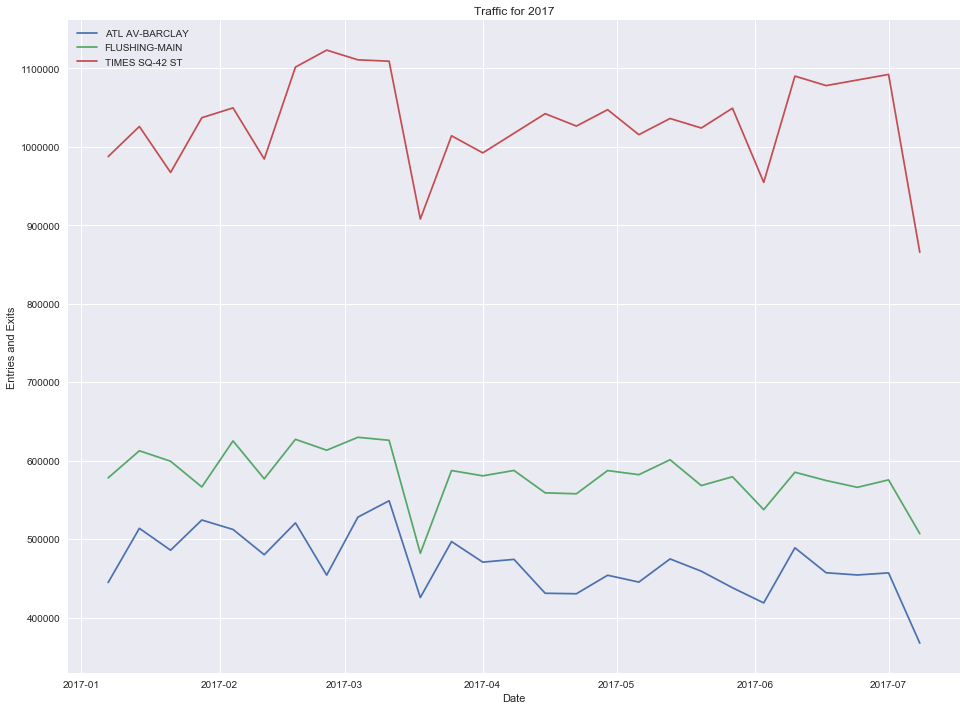

In [54]:
atl_station_17 = final_week_count[(final_week_count.station == 'ATL AV-BARCLAY') & (final_week_count.year == 2017)].reset_index()
flushing_station_17 = final_week_count[(final_week_count.station == 'FLUSHING-MAIN') & (final_week_count.year == 2017)].reset_index()
times_station_17 = final_week_count[(final_week_count.station == 'TIMES SQ-42 ST') & (final_week_count.year == 2017)].reset_index()

plt.plot(atl_station_17.year_week, atl_station_17.total, label='ATL AV-BARCLAY')
plt.plot(flushing_station_17.year_week, flushing_station_17.total, label='FLUSHING-MAIN')
plt.plot(times_station_17.year_week, times_station_17.total, label='TIMES SQ-42 ST')
plt.xlabel('Date')
plt.ylabel('Entries and Exits')
plt.title('Traffic for 2017')
plt.legend(loc='upper left')

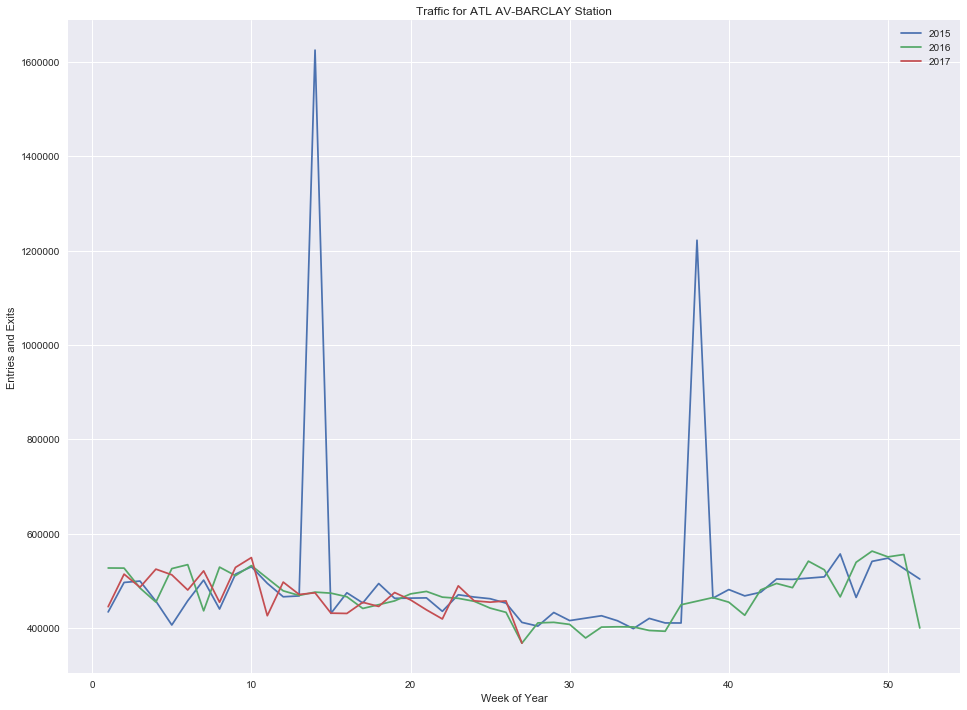

In [55]:
plt.plot(atl_station_15.week_of_year, atl_station_15.total, label='2015')
plt.plot(atl_station_16.week_of_year, atl_station_16.total, label='2016')
plt.plot(atl_station_17.week_of_year, atl_station_17.total, label='2017')
plt.title('Traffic for ATL AV-BARCLAY Station')
plt.xlabel('Week of Year')
plt.ylabel('Entries and Exits')
plt.legend(loc='upper right')

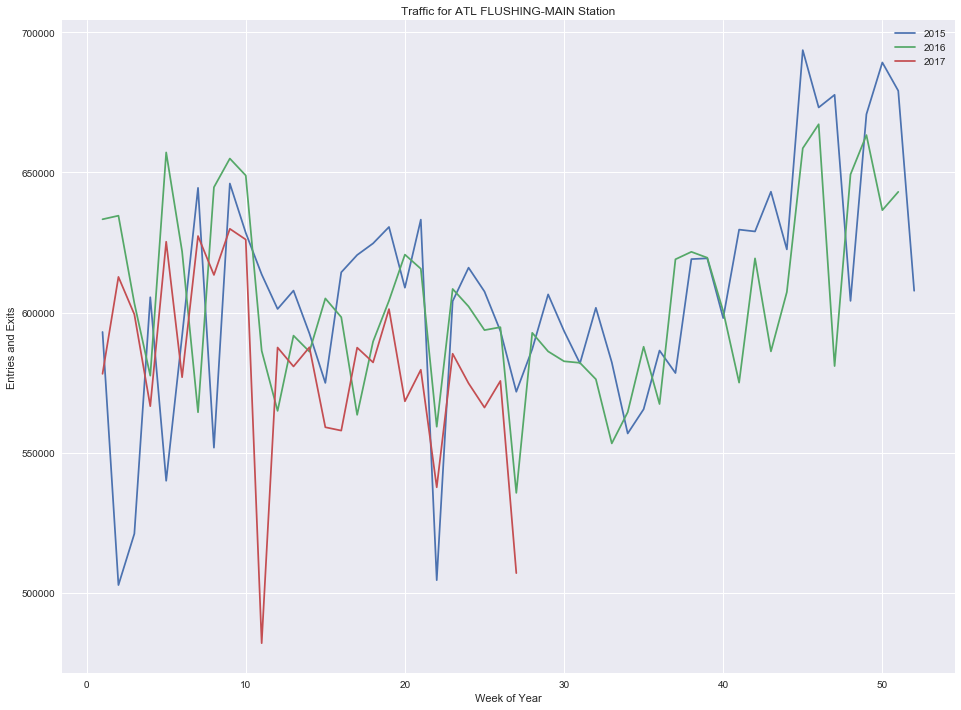

In [56]:
plt.plot(flushing_station_15.week_of_year, flushing_station_15.total, label='2015')
plt.plot(flushing_station_16.week_of_year, flushing_station_16.total, label='2016')
plt.plot(flushing_station_17.week_of_year, flushing_station_17.total, label='2017')
plt.title('Traffic for ATL FLUSHING-MAIN Station')
plt.xlabel('Week of Year')
plt.ylabel('Entries and Exits')
plt.legend(loc='upper right')

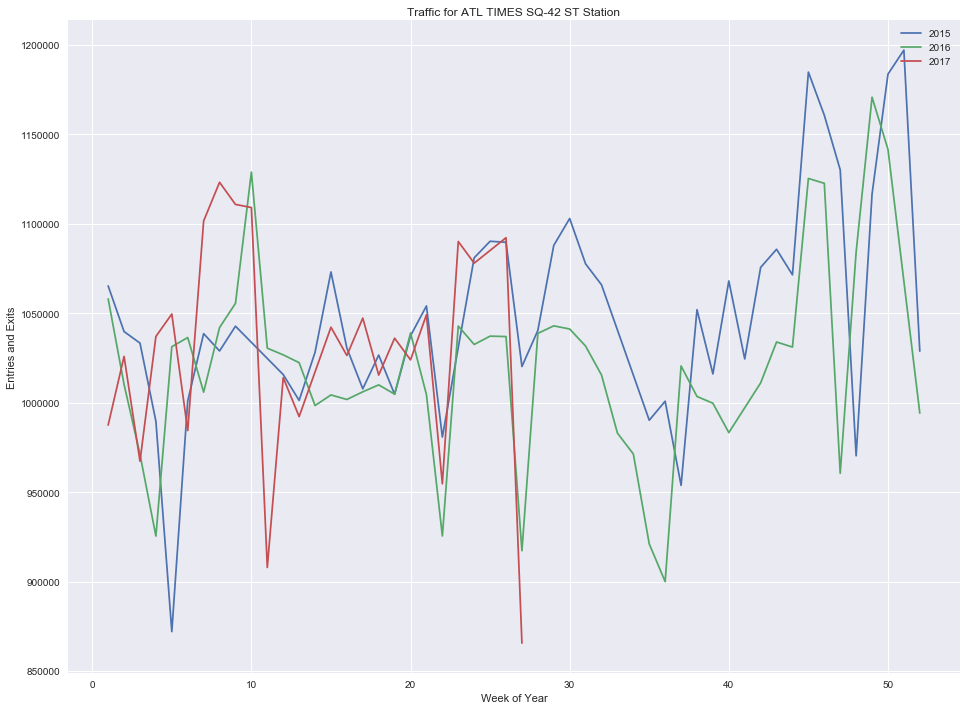

In [57]:
plt.plot(times_station_15.week_of_year, times_station_15.total, label='2015')
plt.plot(times_station_16.week_of_year, times_station_16.total, label='2016')
plt.plot(times_station_17.week_of_year, times_station_17.total, label='2017')
plt.title('Traffic for ATL TIMES SQ-42 ST Station')
plt.xlabel('Week of Year')
plt.ylabel('Entries and Exits')
plt.legend(loc='upper right')

In [46]:
flushing_station_16.head()

,index,station,sum,exit sum,total,year_week,year,week_of_year
0,1,FLUSHING-MAIN,318858,257716,576574,2016-01-02,2015,53
1,1,FLUSHING-MAIN,354160,279135,633295,2016-01-09,2016,1
2,1,FLUSHING-MAIN,354133,280441,634574,2016-01-16,2016,2
3,1,FLUSHING-MAIN,335529,267825,603354,2016-01-23,2016,3
4,1,FLUSHING-MAIN,324132,253376,577508,2016-01-30,2016,4


In [58]:
flushing_station_17.tail()

,index,station,sum,exit sum,total,year_week,year,week_of_year
22,1,FLUSHING-MAIN,342813,242521,585334,2017-06-10,2017,23
23,1,FLUSHING-MAIN,338274,236514,574788,2017-06-17,2017,24
24,1,FLUSHING-MAIN,330041,236095,566136,2017-06-24,2017,25
25,1,FLUSHING-MAIN,334702,240923,575625,2017-07-01,2017,26
26,1,FLUSHING-MAIN,292037,215038,507075,2017-07-08,2017,27
